## Setup

Import the packages we need and the Chronos model wrapper.


In [1]:
import fev
import pandas as pd

from timecopilot import TimeCopilotForecaster
from timecopilot.models.foundation.chronos import Chronos


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


## Load one forecasting window

This task gives us:
- `train_df`: history + past-only features
- `future_df`: known future covariates for the forecast horizon
- `static_df`: static metadata (not used here)


In [2]:
task = fev.Task(
    dataset_path="autogluon/chronos_datasets",
    dataset_config="monash_rideshare",
    horizon=30,
    target="price_mean",
    past_dynamic_columns=["distance_mean", "surge_mean"],  # past-only features
    known_dynamic_columns=["api_calls", "temp", "rain", "humidity", "clouds", "wind"],  # known future covariates
    static_columns=["source_location", "provider_name", "provider_service"],  # static metadata
)

window = task.get_window(0)


## Convert to TimeCopilot format

We convert the window into `train_df`, `future_df`, and `static_df`.


In [3]:
train_df, future_df, static_df = fev.convert_input_data(window, adapter="nixtla")

print("train_df columns:", train_df.columns.tolist())
print("future_df columns:", future_df.columns.tolist())
print("static_df columns:", static_df.columns.tolist())

train_df.head(), future_df.head(), static_df.head()

train_df columns: ['unique_id', 'ds', 'y', 'api_calls', 'clouds', 'humidity', 'rain', 'temp', 'wind', 'distance_mean', 'surge_mean']
future_df columns: ['unique_id', 'ds', 'api_calls', 'clouds', 'humidity', 'rain', 'temp', 'wind']
static_df columns: ['unique_id', 'provider_name', 'provider_service', 'source_location']


(  unique_id                  ds          y  api_calls    clouds  humidity  \
 0   T000000 2018-11-26 06:00:00  16.555555        9.0  0.990667  0.913333   
 1   T000000 2018-11-26 07:00:00  17.299999       10.0  0.970000  0.920000   
 2   T000000 2018-11-26 08:00:00  13.500000        1.0  0.980000  0.923333   
 3   T000000 2018-11-26 09:00:00  17.954546       11.0  1.000000  0.927500   
 4   T000000 2018-11-26 10:00:00  18.625000       12.0  0.995000  0.940000   
 
    rain       temp      wind  distance_mean  surge_mean  
 0   0.0  40.627335  1.350667       1.726667    1.055556  
 1   0.0  41.137501  1.735000       1.690000    1.100000  
 2   0.0  40.919998  1.330000       1.380000    1.000000  
 3   0.0  40.937500  1.365000       1.920909    1.113636  
 4   0.0  40.695000  1.895000       2.122500    1.083333  ,
   unique_id                  ds  api_calls  clouds  humidity  rain       temp  \
 0   T000000 2018-12-17 13:00:00       10.0    0.97      0.90   0.0  35.169998   
 1   T00000

## Figure out which columns are covariates

- past-only covariates: present in `train_df`, not in `future_df`
- known future covariates: present in `future_df` (excluding id + time)


In [4]:
base_cols = ["unique_id", "ds", "y"]

past_only_covs = [
    c for c in train_df.columns
    if c not in base_cols and c not in future_df.columns
]
known_future_covs = [c for c in future_df.columns if c not in ["unique_id", "ds"]]

print("past_only_covs:", past_only_covs)
print("known_future_covs:", known_future_covs)


past_only_covs: ['distance_mean', 'surge_mean']
known_future_covs: ['api_calls', 'clouds', 'humidity', 'rain', 'temp', 'wind']


## Make sure covariates are numeric

Chronos-2 expects numeric covariates.


In [5]:
for c in past_only_covs:
    train_df[c] = pd.to_numeric(train_df[c], errors="raise")

for c in known_future_covs:
    future_df[c] = pd.to_numeric(future_df[c], errors="raise")


## Build the forecaster

We use Chronos-2 and pass exogenous variables through `forecast()` using:
- `static_features`: past-only covariates in `train_df`
- `X_df`: known future covariates in `future_df`


In [6]:
model = Chronos(
    repo_id="amazon/chronos-2",
    alias="chronos2_exog",
)

tcf = TimeCopilotForecaster(models=[model])


## Forecast

We forecast the next 30 steps and also ask for an 80% interval.


In [7]:
h = 30

fcst = tcf.forecast(
    df=train_df,
    h=h,
    X_df=future_df,
    static_features=past_only_covs,
    level=[80],
)

fcst.head(20)


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

,unique_id,ds,chronos2_exog,chronos2_exog-lo-80,chronos2_exog-hi-80
0,T000000,2018-12-17 13:00:00,16.750,14.8125,18.750
1,T000000,2018-12-17 14:00:00,16.750,14.8750,18.875
2,T000000,2018-12-17 15:00:00,16.750,14.8750,18.875
3,T000000,2018-12-17 16:00:00,16.750,14.9375,18.875
4,T000000,2018-12-17 17:00:00,16.750,14.8125,18.750
5,T000000,2018-12-17 18:00:00,16.750,14.9375,18.750
6,T000000,2018-12-17 19:00:00,16.750,14.9375,18.625
7,T000000,2018-12-17 20:00:00,16.875,15.0000,18.750
8,T000000,2018-12-17 21:00:00,16.875,15.0000,18.750
9,T000000,2018-12-17 22:00:00,16.750,15.0000,18.750


## Plot one series

Pick one `unique_id` and plot history + forecast + interval.


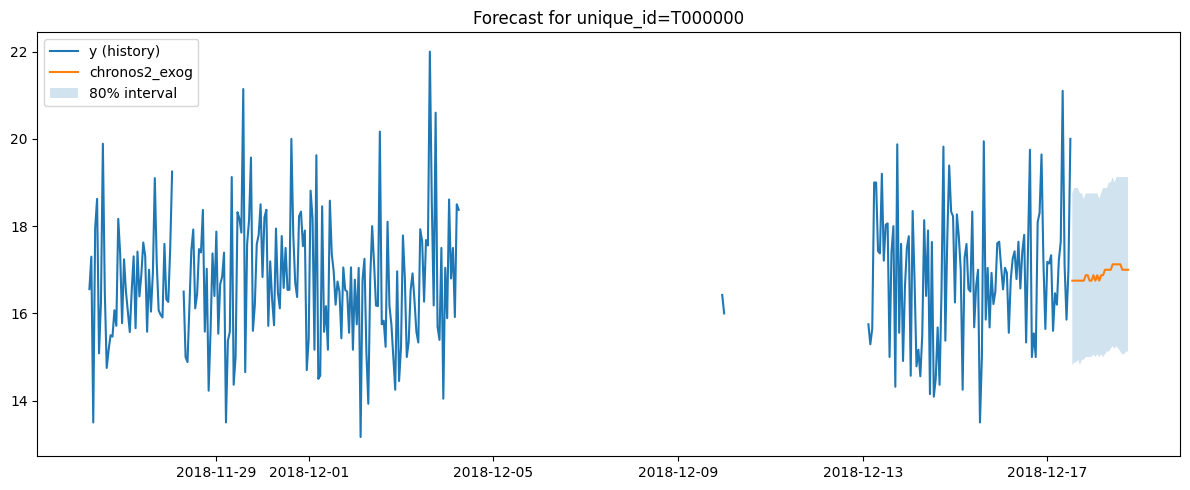

In [8]:
import matplotlib.pyplot as plt

model_col = "chronos2_exog"
uid = train_df["unique_id"].iloc[0]
lv = 80

train_u = train_df.loc[train_df["unique_id"] == uid, ["ds", "y"]].copy()
fcst_u = fcst.loc[
    fcst["unique_id"] == uid,
    ["ds", model_col, f"{model_col}-lo-{lv}", f"{model_col}-hi-{lv}"],
].copy()

train_u["ds"] = pd.to_datetime(train_u["ds"])
fcst_u["ds"] = pd.to_datetime(fcst_u["ds"])
train_u = train_u.sort_values("ds")
fcst_u = fcst_u.sort_values("ds")

plt.figure(figsize=(12, 5))
plt.plot(train_u["ds"], train_u["y"], label="y (history)")
plt.plot(fcst_u["ds"], fcst_u[model_col], label=model_col)
plt.fill_between(
    fcst_u["ds"],
    fcst_u[f"{model_col}-lo-{lv}"],
    fcst_u[f"{model_col}-hi-{lv}"],
    alpha=0.2,
    label=f"{lv}% interval",
)
plt.title(f"Forecast for unique_id={uid}")
plt.legend()
plt.tight_layout()
plt.show()
